# Colab shell


In [1]:
from IPython.display import JSON
from google.colab import output
from subprocess import getoutput
import os

def shell(command):
  if command.startswith('cd'):
    path = command.strip().split(maxsplit=1)[1]
    os.chdir(path)
    return JSON([''])
  return JSON([getoutput(command)])
output.register_callback('shell', shell)

Open a shell session in Colab notebooks using Python and JQuery.

In [2]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

In [3]:
import numpy as np
data_dir = '/content/drive/My Drive/project/'
X_test = np.load(data_dir + "X_test.npy")
y_test = np.load(data_dir + "y_test.npy")
person_train_valid = np.load(data_dir + "person_train_valid.npy")
X_train_valid = np.load(data_dir + "X_train_valid.npy")
y_train_valid = np.load(data_dir + "y_train_valid.npy")
person_test = np.load(data_dir + "person_test.npy")

In [ ]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))


Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [4]:
from sklearn import preprocessing

In [5]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y

# calling the preprocessing function
X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)

Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of X after subsampling and concatenating: (8460, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)


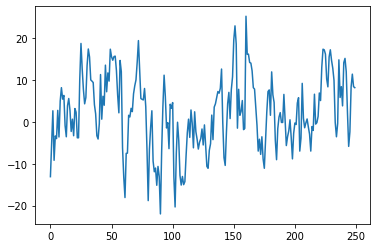

In [6]:
# visualize a sample
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(X_test_prep[3, 14, :])

In [7]:
np.random.seed(0)

In [8]:
# Turn labels into categories, i.e. y values of 0-3
le = preprocessing.LabelEncoder()
le.fit(y_train_valid_prep)
y_train_valid_classes = le.transform(y_train_valid_prep)
y_test_classes = le.transform(y_test_prep)

In [9]:
rand_idx = np.random.permutation(X_train_valid_prep.shape[0])
split = int(X_train_valid_prep.shape[0] * 0.80)

In [10]:
# Create randomized train and validation dataset split
X_train = X_train_valid_prep[rand_idx][:split]
y_train = y_train_valid_classes[rand_idx][:split]

X_valid = X_train_valid_prep[rand_idx][split:]
y_valid = y_train_valid_classes[rand_idx][split:]

In [11]:
num_trials = X_train.shape[0]
num_timesteps = X_train.shape[2]
num_features = X_train.shape[1]

print(num_timesteps)
print(num_features)

print("Hi")

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

250
22
Hi
(6768, 22, 250)
(6768,)
(1692, 22, 250)
(1692,)


In [12]:
# swapping axes
X_test_prep = X_test_prep.transpose([0, 2, 1])
X_train = X_train.transpose([0, 2, 1])
X_valid = X_valid.transpose([0, 2, 1])

print(X_train.shape)
print(X_valid.shape)
print(X_test_prep.shape)

(6768, 250, 22)
(1692, 250, 22)
(1772, 250, 22)


In [13]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation, Flatten
from keras import optimizers
from keras import regularizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model

In [14]:
checkpoint_path = data_dir + 'checkpoints/EEG_RNN.ckpt'
model_json_path = data_dir + 'checkpoints/EEG_RNN.json'
import keras.callbacks

# Create checkpoint callback
cp_callback = keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True, 
                                                 monitor='val_loss',
                                                 save_best_only=True, 
                                                 mode='auto',
                                                 verbose=1)

In [16]:
# Build model architecture
model = Sequential()

model.add(LSTM(30, recurrent_dropout=0.25, kernel_regularizer=regularizers.l2(0.01), input_shape=(num_timesteps, num_features), return_sequences=True))
model.add(BatchNormalization())

model.add(LSTM(16, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=regularizers.l2(0.03)))
model.add(BatchNormalization())

model.add(Dropout(0.3))

model.add(Dense(4, activation='softmax', kernel_regularizer=regularizers.l2(0.05)))

In [17]:
model.summary()
with open(model_json_path, 'w') as f:
   f.write(model.to_json())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 250, 30)           6360      
                                                                 
 batch_normalization (BatchN  (None, 250, 30)          120       
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 16)                3008      
                                                                 
 batch_normalization_1 (Batc  (None, 16)               64        
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 4)                 6

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=200, batch_size=64, callbacks=[cp_callback])

(6768, 250, 22)
(6768,)
(1692, 250, 22)
(1692,)
Epoch 1/200
106/106 [==============================] - ETA: 0s - loss: 3.3993 - accuracy: 0.2528
Epoch 1: val_loss improved from inf to 2.71350, saving model to /content/drive/My Drive/project/checkpoints/EEG_RNN.ckpt
106/106 [==============================] - 64s 491ms/step - loss: 3.3993 - accuracy: 0.2528 - val_loss: 2.7135 - val_accuracy: 0.2695
Epoch 2/200
106/106 [==============================] - ETA: 0s - loss: 2.5968 - accuracy: 0.2769
Epoch 2: val_loss improved from 2.71350 to 2.27022, saving model to /content/drive/My Drive/project/checkpoints/EEG_RNN.ckpt
106/106 [==============================] - 53s 500ms/step - loss: 2.5968 - accuracy: 0.2769 - val_loss: 2.2702 - val_accuracy: 0.2943
Epoch 3/200
106/106 [==============================] - ETA: 0s - loss: 2.1792 - accuracy: 0.2945
Epoch 3: val_loss improved from 2.27022 to 1.99980, saving model to /content/drive/My Drive/project/checkpoints/EEG_RNN.ckpt
106/106 [=============

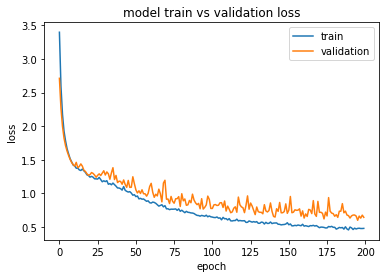

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
# plot train and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()